# Alterations to CMAQ emission inputs

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** needham.michael@epa.gov

**Description:** Builds on the previous example (__[Example 2](./02_hr2day_output_analysis_example.ipynb)__) to demonstrate the following funcionality:
* Download AQS monitor data using the __[pyRSIG](https://barronh.github.io/pyrsig/)__ package
* Compare AQS data to CMAQ output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np

import shapely
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt


ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


## 1. Data I/O

<div class="alert alert-block alert-warning">
The file in this tutorial (<code>./tutorial_data/emis_mole_NOX_20180501_12US1_2018gg_18j.ncf</code> is a subset containing only the variables <b>NO</b> and <b>NO2</b> from a full emissions file. This subsetting was done to allow the smaller file to be uploaded to the GitHub repo.
</div>

In [3]:
from src.utils.cmaq import get_cmaq_projection, get_cmaq_metadata

In [4]:
file = Path("./tutorial_data/emis_mole_NOX_20180501_12US1_2018gg_18j.ncf")

dset = get_cmaq_metadata(xr.open_dataset(file)).isel(LAY=0)
proj = get_cmaq_projection(dset)

dset

<xarray.Dataset> Size: 27MB
Dimensions:  (time: 25, y: 299, x: 459)
Coordinates:
  * x        (x) float64 4kB 0.0 1.2e+04 2.4e+04 ... 5.484e+06 5.496e+06
  * y        (y) float64 2kB 0.0 1.2e+04 2.4e+04 ... 3.564e+06 3.576e+06
  * time     (time) datetime64[ns] 200B 2018-05-01 ... 2018-05-02
Data variables:
    NO       (time, y, x) float32 14MB ...
    NO2      (time, y, x) float32 14MB ...
Attributes: (12/35)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 98 2018-04-05 14:35:07Z coats $...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2022167
    CTIME:          12023
    WDATE:          2022167
    ...             ...
    UPNAM:          MRGGRID         
    VAR-LIST:       AACD            ACET            ACROLEIN        ALD2     ...
    FILEDESC:       Merged emissions output file from Mrggrid                ...
    HISTORY:        
    DESCRIPTION:    Sum of files:  /work/EMIS/em_v6.3/ocean_cl2/cl2_12US1.ncf...
    UPDATE:         UPDATE 2024-07-18. THIS NETCDF FILE IS A SUBSET OF AN EXI...

## 2. Subsetting

Zoom in from the full domain to St. Louis. For this, we will use __[geopandas](https://geopandas.org/en/stable/)__ as a coordinate-aware wrapper around __[shapely.polygons](https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html)__, and then use __[shapely.envelope](https://shapely.readthedocs.io/en/maint-2.0/reference/shapely.envelope.html)__ to draw a rectangle in Lambert coordinates that is parallel to the lambert axes that fully encompases the rectangle in Lat/Lon coordinates. Note that the resulting subset will be slightly larger and offset from the specified bounding box (see red frame in the maps below). For more information, see __[Auxiliary Example A3](./A3_coordinate_transformation_subsetting.ipynb)__

In [5]:
# Latitude and Longitude coordinates of desired bounding box
x0 = -94
y0 = 36.125
x1 = -86
y1 = 40

# Create the shapely object
rect_latlon = shapely.Polygon(shell=[(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

rect_latlon = gpd.GeoDataFrame(geometry=[rect_latlon], crs=ccrs.PlateCarree())

# Draw the bounding envelope. Need to convert rect_latlon to the lambert proj
# so that the result of shapely.envelope is parallel to the lambert axes
rect_lambert = shapely.envelope(rect_latlon.to_crs(proj))
rect_lambert.crs = proj

In [6]:
rect_lambert_coords = rect_lambert.geometry.iloc[0].boundary.coords.xy

xA = rect_lambert_coords[0][0]
xB = rect_lambert_coords[0][1]

yA = rect_lambert_coords[1][0]
yB = rect_lambert_coords[1][2]

dset_stl = dset.sel(x=slice(xA, xB), y=slice(yA, yB))

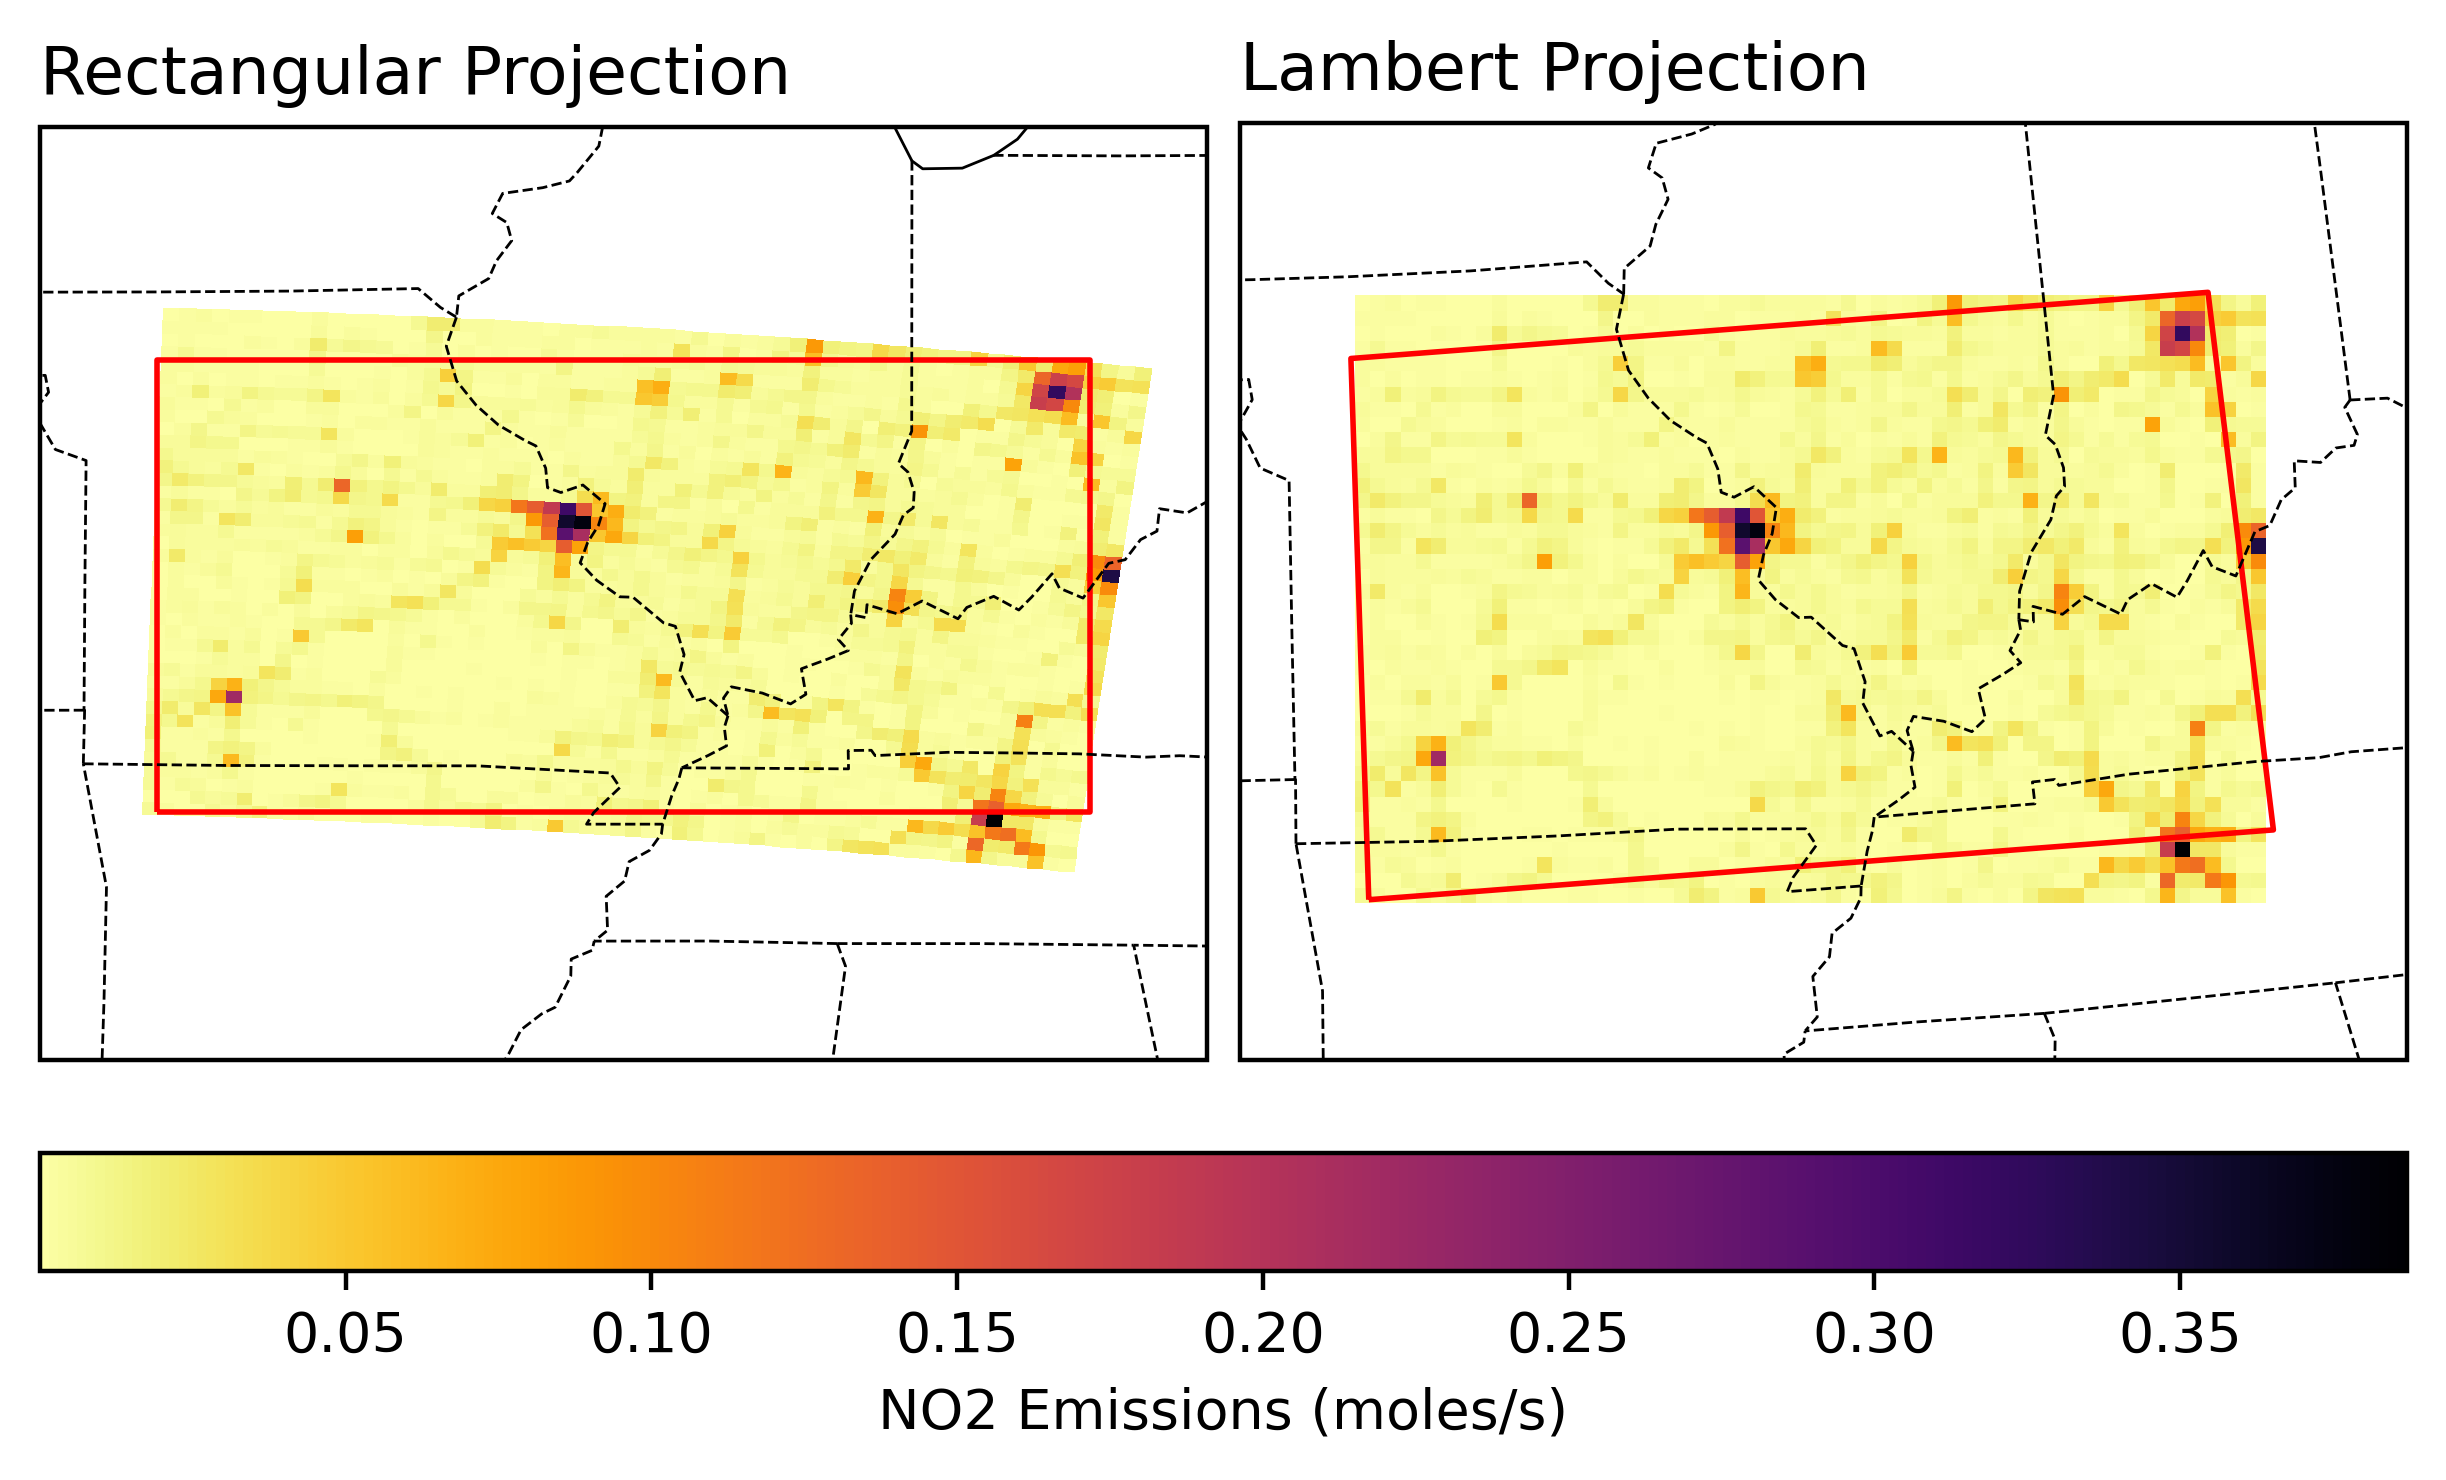

In [7]:
varname = "NO2"


states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="110m",
)


fig = plt.figure(dpi=400, figsize=(6, 5), layout="constrained")

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=proj)

for ax in [ax1, ax2]:

    ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
    ax.add_feature(cfeature.LAKES.with_scale("110m"), ec="k", fc="none", lw=0.5)
    ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="--")
    ax.coastlines(color="k", lw=0.75)

    cs = ax.pcolormesh(
        dset_stl.x,
        dset_stl.y,
        dset_stl[varname].isel(time=0),
        transform=proj,
        cmap="inferno_r",
    )

    rect_latlon.plot(
        ax=ax, facecolor="none", edgecolor="r", transform=ccrs.PlateCarree()
    )
    # rect_lambert.plot(ax=ax,facecolor='none',edgecolor='r',transform=proj)


ax1.set_extent([-95, -85, 34, 42], crs=ccrs.PlateCarree())
ax2.set_extent([-95, -85, 35, 41.125], crs=ccrs.PlateCarree())

ax1.set_title("Rectangular Projection", loc="left")
ax2.set_title("Lambert Projection", loc="left")

cbar = fig.colorbar(cs, ax=[ax1, ax2], location="bottom")
cbar.set_label(f"{varname} Emissions ({dset_stl[varname].units.strip()})")

## 3. Reduce NOx Emissions 

#### 3.1 Reduction by a Constant Factor

For this first example, will reduce NO$_x$ emissions (NO + NO$_2$) by 20% across the greater St. Louis region while keeping all other emissions constant

In [8]:
nox = ["NO", "NO2"]
reduction = 0.2
factor = 1 - reduction

In [9]:
# Start by copying the original dset_stl
dset_stl_ex1 = dset_stl.copy()

for var in nox:
    dset_stl_ex1[var] = dset_stl[var] * factor

nox_change_ex1 = (dset_stl_ex1["NO2"] + dset_stl_ex1["NO"]) - (
    dset_stl["NO2"] + dset_stl["NO"]
)

#### 3.2 Reduction only in high-NOx regions

For this second example, we will reduce NO$_x$ emissions by that same 10% factor, but only from gridcells that are currently above the 90th percentile in NO$_x$ emissions.

In [10]:
# Start by copying the original dset_stl
dset_stl_ex2 = dset_stl.copy()

pct_thr = 90

# Sum over the time emission to find the total emissions of NOx at
# each gridcells with the largest amount over an entire day
var_daily_total = (dset_stl["NO"] + dset_stl["NO2"]).sum(dim="time")

# Find gridcells that are above the percentile threshold
thr_region = float(var_daily_total.quantile(pct_thr / 100))

# Make a boolean mask (2D)
mask = var_daily_total > thr_region

for var in nox:

    # Only perform the reduction where mask == True. Otherwise, take values
    # from the original array
    dset_stl_ex2[var] = xr.where(mask, dset_stl[var] * factor, dset_stl[var])

nox_change_ex2 = (dset_stl_ex2["NO2"] + dset_stl_ex2["NO"]) - (
    dset_stl["NO2"] + dset_stl["NO"]
)

#### 3.3 Reduction only during certain hours

For this third example, we will reduce NO$_x$ emissions by that same 20% factor, but only between the hours of 12Z-15Z (7 - 10AM local time)

In [20]:
# Start by copying the original dset_stl
dset_stl_ex3 = dset_stl.copy()

hr1 = 12
hr2 = 15

for var in nox:

    # Only perform the reduction where mask == True. Otherwise, take values
    # from the original array
    dset_stl_ex3[var] = xr.where(
        np.logical_and(dset_stl["time.hour"] >= hr1, dset_stl["time.hour"] <= hr2),
        dset_stl[var] * factor,
        dset_stl[var],
    )

nox_change_ex3 = (dset_stl_ex3["NO2"] + dset_stl_ex3["NO"]) - (
    dset_stl["NO2"] + dset_stl["NO"]
)

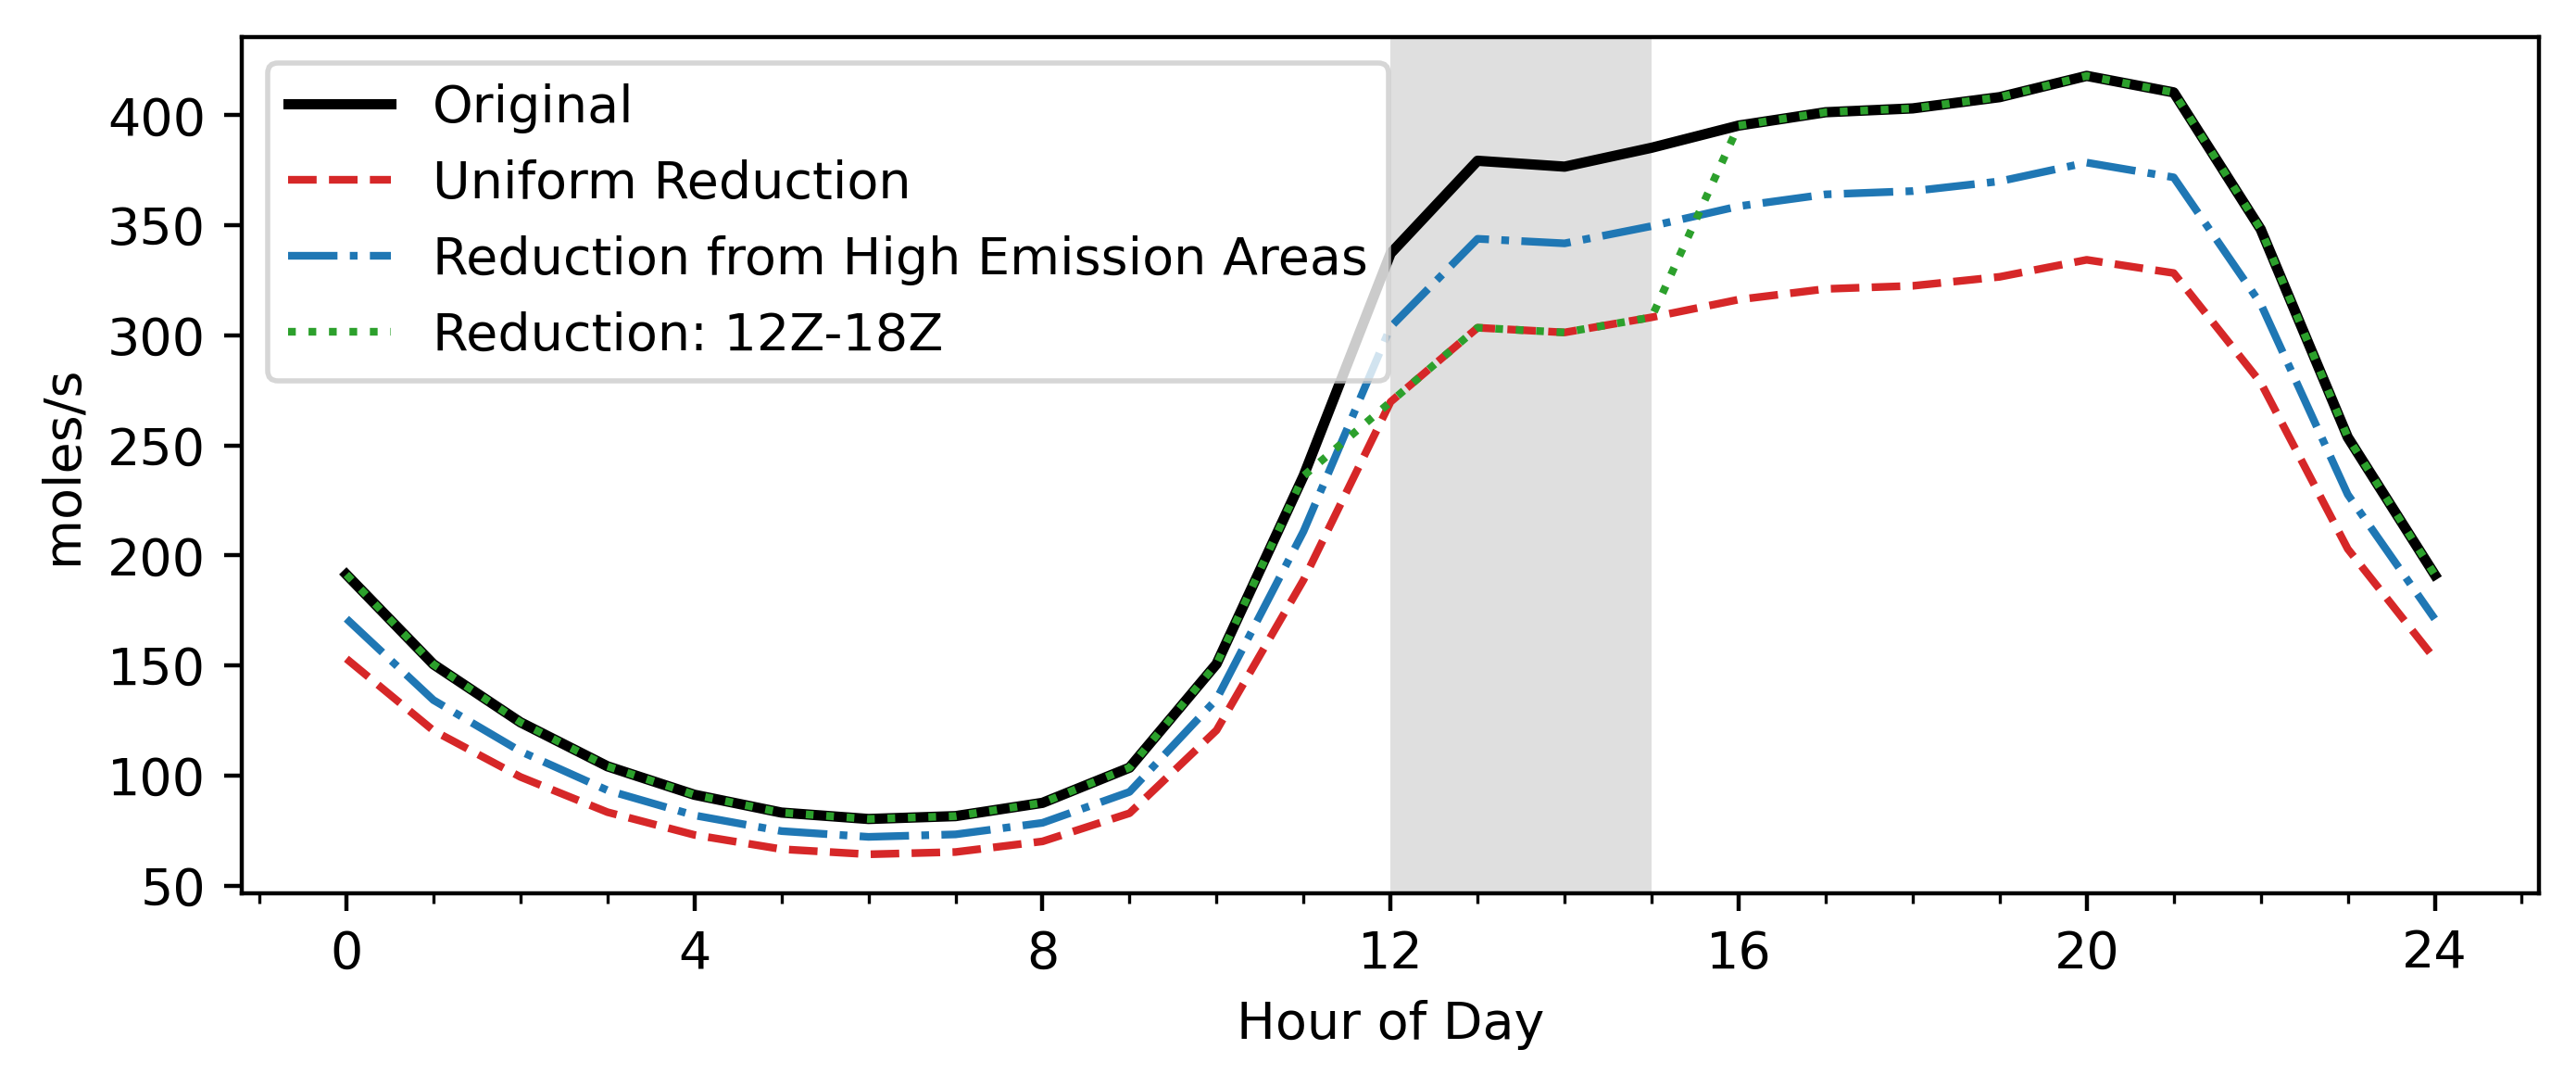

In [22]:
# Make a quick plot of the diurnal cycle of total NOx emissions

fig, ax = plt.subplots(figsize=(8, 3), dpi=400)

ax.plot(
    (dset_stl["NO2"] + dset_stl["NO"]).sum(dim=("y", "x")),
    label="Original",
    color="k",
    lw=2,
)

ax.plot(
    (dset_stl_ex1["NO2"] + dset_stl_ex1["NO"]).sum(dim=("y", "x")),
    label="Uniform Reduction",
    color="tab:red",
    ls="--",
)
ax.plot(
    (dset_stl_ex2["NO2"] + dset_stl_ex2["NO"]).sum(dim=("y", "x")),
    label="Reduction from High Emission Areas",
    color="tab:blue",
    ls="-.",
)
ax.plot(
    (dset_stl_ex3["NO2"] + dset_stl_ex3["NO"]).sum(dim=("y", "x")),
    label="Reduction: 12Z-18Z",
    color="tab:green",
    ls=":",
)

ax.set_xlabel("Hour of Day")
ax.set_ylabel("moles/s")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.axvspan(hr1, hr2, color="grey", ec="none", alpha=0.25)

ax.legend()

Colormap breakpoints: [-30000. -28500. -27000. -25500. -24000. -22500. -21000. -19500. -18000.
 -16500. -15000. -13500. -12000. -10500.  -9000.  -7500.  -6000.  -4500.
  -3000.  -1500.      0.]


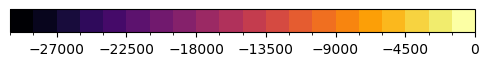

In [13]:
# Setup the desired colorbar
vmin = -30000
vmax = 0
dlev = 1500
levels = np.arange(vmin, vmax + dlev / 2, dlev)

cmap = mpl.colormaps["inferno"]
cmap.set_bad("gainsboro")
norm = mpl.colors.BoundaryNorm(ncolors=cmap.N, boundaries=levels)
smap = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

print(f"Colormap breakpoints: {levels}")

# These two lines are just included to dispaly the colorbar
fig, ax = plt.subplots(figsize=(6, 0.3))
fig.colorbar(smap, cax=ax, orientation="horizontal")

Text(0.0, 1.0, '20% Reduction: 12Z-15Z')

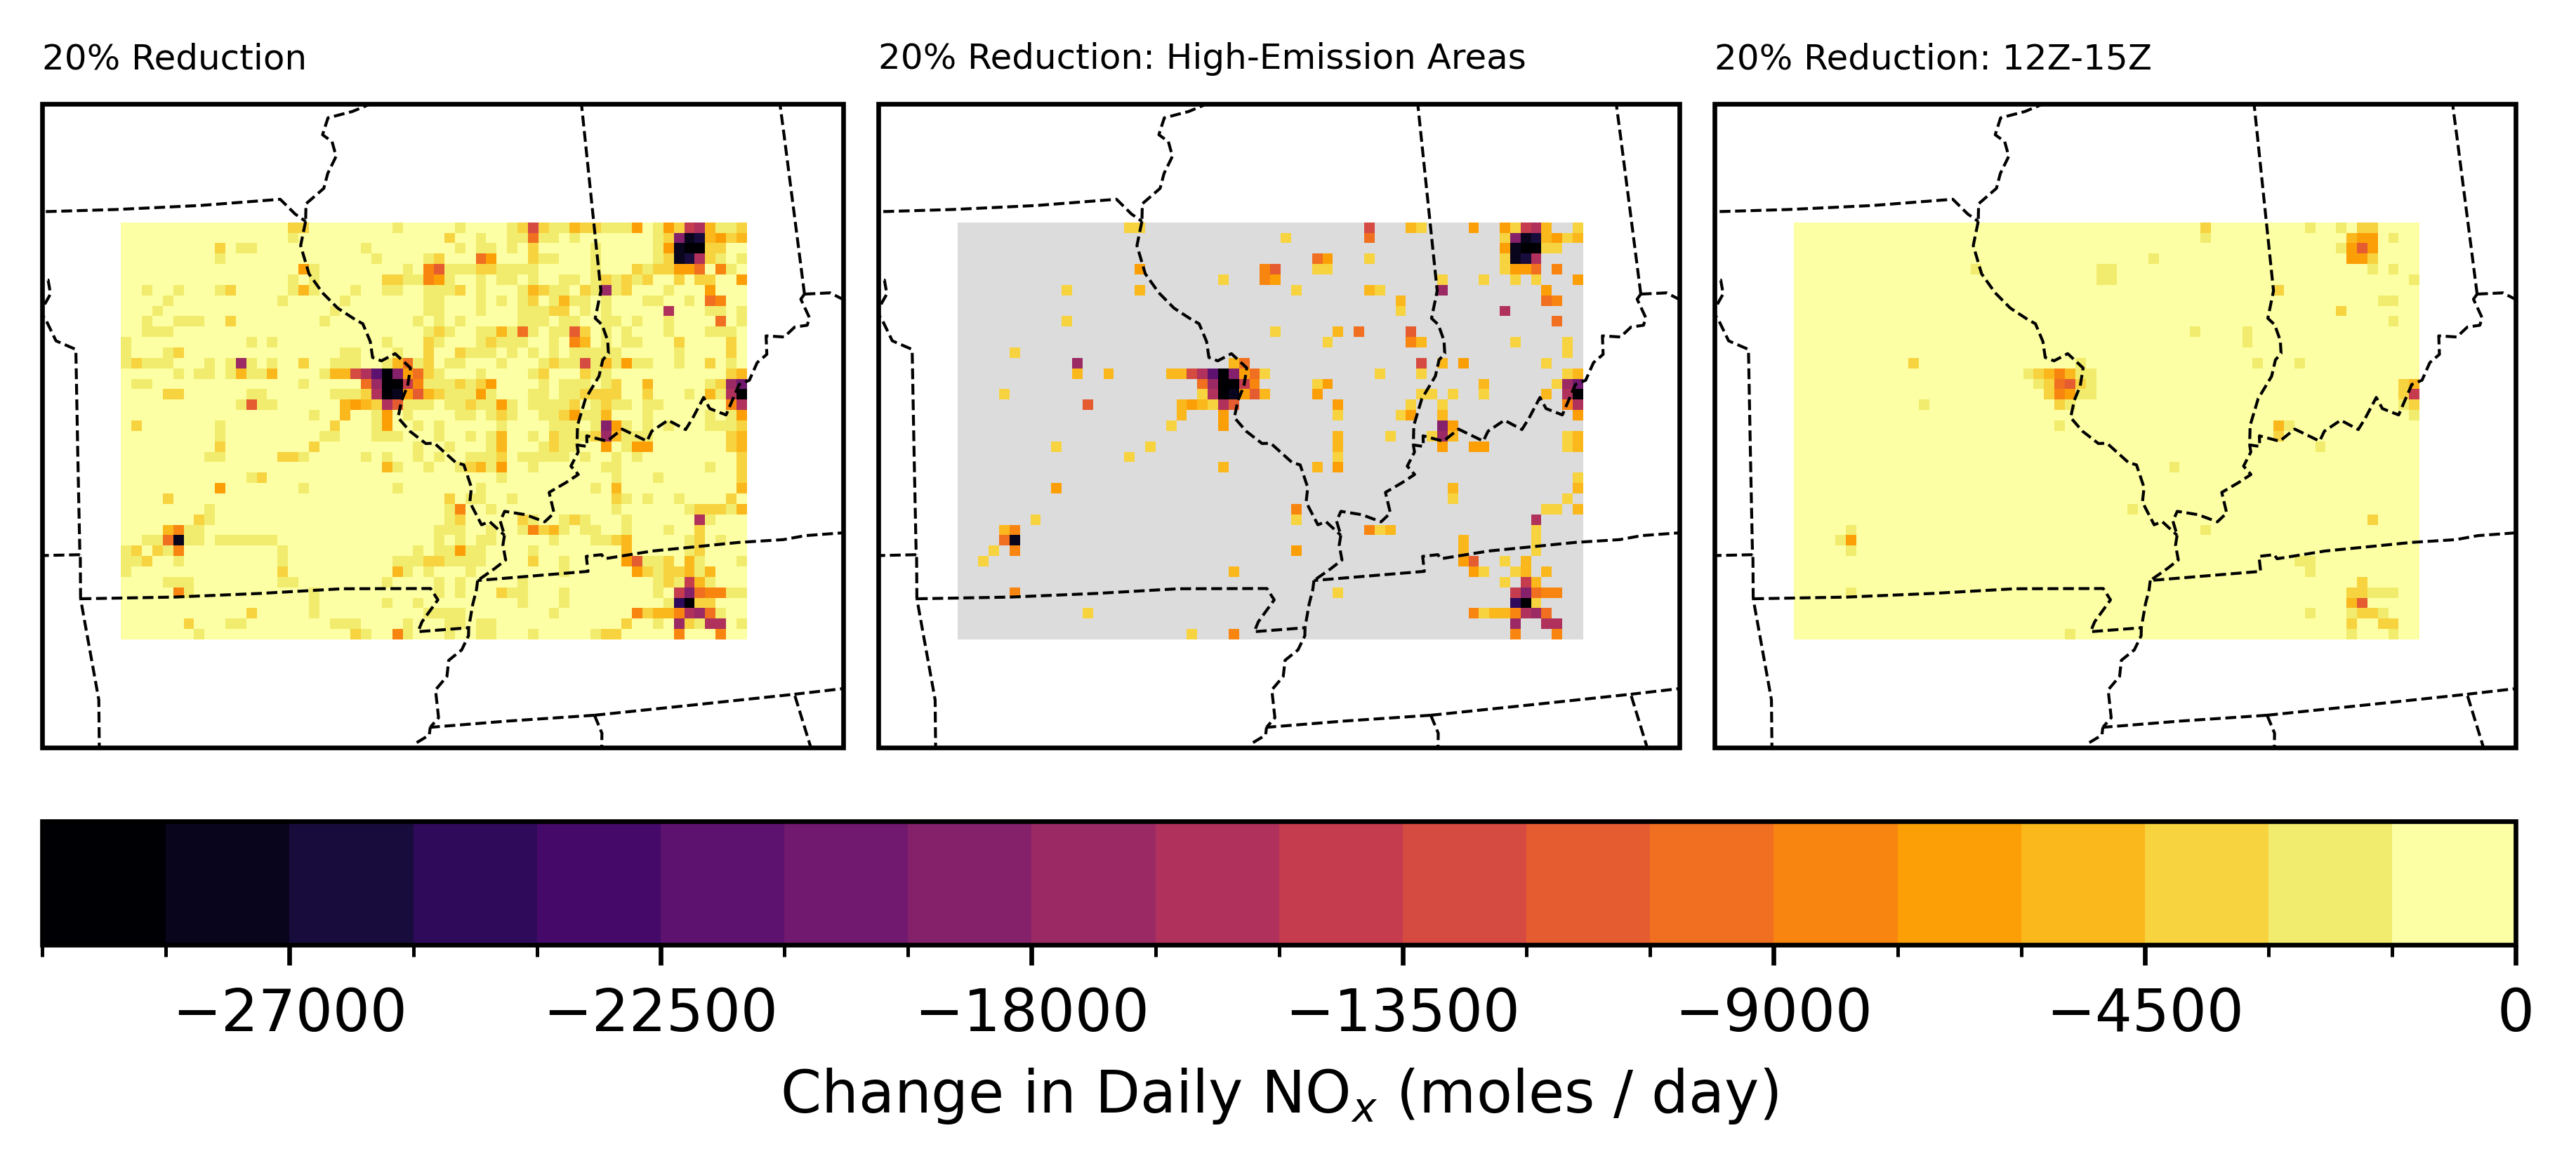

In [14]:
# emission factor for calculating moles / day by summing averaged moles/s
emiss_factor = 3600  # seconds/hour

fig, axs = plt.subplots(
    ncols=3,
    subplot_kw=dict(projection=proj),
    figsize=(6, 4),
    dpi=600,
    layout="constrained",
)

ax1, ax2, ax3 = axs

for ax in axs:
    ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
    ax.add_feature(cfeature.LAKES.with_scale("110m"), ec="k", fc="none", lw=0.5)
    ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="--")
    ax.coastlines(color="k", lw=0.75)
    ax.set_extent([-95, -85, 35, 41.125], crs=ccrs.PlateCarree())

ax1.pcolormesh(
    dset_stl.x,
    dset_stl.y,
    nox_change_ex1.sum(dim="time") * emiss_factor,
    transform=proj,
    cmap=cmap,
    norm=norm,
)
ax3.pcolormesh(
    dset_stl.x,
    dset_stl.y,
    nox_change_ex3.sum(dim="time") * emiss_factor,
    transform=proj,
    cmap=cmap,
    norm=norm,
)

# For the second plot, explicitly mask where the change is equal to zero for plotting purposes
data2 = nox_change_ex2.sum(dim="time") * emiss_factor
ax2.pcolormesh(
    dset_stl.x,
    dset_stl.y,
    np.ma.masked_where(data2 == 0, data2),
    transform=proj,
    cmap=cmap,
    norm=norm,
)

cbar = fig.colorbar(smap, ax=axs, location="bottom")
cbar.set_label("Change in Daily NO$_x$ (moles / day)")

fs = 6
ax1.set_title(f"{reduction*100:.0f}% Reduction", fontsize=fs, loc="left")
ax2.set_title(
    f"{reduction*100:.0f}% Reduction: High-Emission Areas", fontsize=fs, loc="left"
)
ax3.set_title(f"{reduction*100:.0f}% Reduction: 12Z-15Z", fontsize=fs, loc="left")